In [47]:
# Libraries and utilities

import pandas as pd
import numpy  as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler,MinMaxScaler,StandardScaler, OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedKFold,RepeatedStratifiedKFold, RandomizedSearchCV,GridSearchCV, RepeatedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix
)

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.model_selection import learning_curve

from sklearn.neighbors import NearestNeighbors 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from pyod.models.abod import ABOD
from pyod.models.knn import KNN

In [48]:
df_train=pd.read_csv("../Dataset_prepared/Prepared_train.csv")
df_test=pd.read_csv("../Dataset_prepared/Prepared_test.csv")

df_train.drop('actor',axis=1,inplace=True)
df_train.drop('filename',axis=1,inplace=True)

df_test.drop('actor',axis=1,inplace=True)
df_test.drop('filename',axis=1,inplace=True)

# One-hot encoding
cat_var=["statement","repetition","sex","emotional_intensity","vocal_channel"]
le=preprocessing.LabelEncoder()
for i in cat_var:
    df_train[i]=le.fit_transform(df_train[i])
categorical_col = ["emotion"]

df_train = pd.get_dummies(df_train, columns=categorical_col)    

"""
# Label encoding for train and test
le=preprocessing.LabelEncoder()
c = df_train.select_dtypes(include=['object']).columns.tolist()
for i in c:
    df_train[i]=le.fit_transform(df_train[i])
for i in c:
    df_test[i]=le.fit_transform(df_test[i])
"""

"""

# Normalization of train and test
scaler = StandardScaler()
numeric_features = [n for n in df_train.columns if n!="emotion_angry" and n!="emotion_calm" and  n!="emotion_disgust" and  n!="emotion_fearful" and  n!="emotion_happy" and  n!="emotion_neutral" and n!="emotion_sad" and  n!="emotion_surprised" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex" and n!="filename" and n!="actor"]
scaled_features = scaler.fit_transform(df_train[numeric_features])
df_train[numeric_features] = scaled_features
scaled_features_test = scaler.transform(df_test[numeric_features])
df_test[numeric_features] = scaled_features_test

"""

'\n\n# Normalization of train and test\nscaler = StandardScaler()\nnumeric_features = [n for n in df_train.columns if n!="emotion_angry" and n!="emotion_calm" and  n!="emotion_disgust" and  n!="emotion_fearful" and  n!="emotion_happy" and  n!="emotion_neutral" and n!="emotion_sad" and  n!="emotion_surprised" and n!= "vocal_channel" and n!= "emotional_intensity" and n!= "statement" and n!= "repetition" and n!= "sex" and n!="filename" and n!="actor"]\nscaled_features = scaler.fit_transform(df_train[numeric_features])\ndf_train[numeric_features] = scaled_features\nscaled_features_test = scaler.transform(df_test[numeric_features])\ndf_test[numeric_features] = scaled_features_test\n\n'

In [49]:
df_train.head()

,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_kur_w4,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised
0,1,0,1,0,1,9.150000e-07,-0.000031,0.0,0.0,15.028520,...,6.742190,-1.706215,0,0,0,0,0,1,0,0
1,1,0,1,1,1,7.137790e-07,-0.000031,0.0,0.0,16.488415,...,-0.700420,-0.201495,0,0,0,0,0,1,0,0
2,1,0,0,0,1,9.554485e-07,0.000000,0.0,0.0,17.035218,...,1.688986,-1.024773,0,0,0,0,0,1,0,0
3,1,0,0,1,1,9.176213e-07,-0.000031,0.0,0.0,21.824521,...,-0.594111,-0.412871,0,0,0,0,0,1,0,0
4,1,0,1,0,1,8.108948e-07,-0.000031,0.0,0.0,13.236022,...,0.126535,-0.620782,0,1,0,0,0,0,0,0


In [50]:
train=df_train.values
test=df_test.values

Now we experiments different technics to detect Outliers belonging to different families:
- Density-based approach (LOF,DBSCAN)
- Distance-Based approach (KNN)
- Angle-Based approach (ABOD)
- Model-based approach (Isolation Forest) 

After detecting all outliers  we analyze each set returned from the different approach and try to compare them quantitatively.
We will do some scatter plots in 2/3D to see how they are distributed with the Inliers
We will intersect the 1% otuliers detected  among the the different sets returned by each approach.
We will intersect the top 10 outliers detected, for a better comparison, among the different sets returned by each approach.

# Desnity-based approach

LOF (Outliers are those values with LOF Score >> 1,-1)

In [51]:
#tuning n_neighbours hyperparameter

col = [x for x in df_train.columns if x!='emotional_intensity']
X_train=df_train[col].values
y_train = np.array(df_train["emotional_intensity"])

n = 30 # Max number of neighbours you want to consider
param_grid = {'n_neighbors': np.arange(n)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(X_train, y_train)

c:\Users\david\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\david\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\david\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 207, in fit
    return self._fit(X, y)
  File "c:\Users\david\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 603, in _fit
    raise ValueError("Expected n_neighbors > 0. Got %d" % self.n_neighbors)
Val

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])})

In [52]:
grid.best_params_

{'n_neighbors': 17}

In [59]:
clf_LOF = LocalOutlierFactor(n_neighbors = 17)
y_pred = clf_LOF.fit_predict(train)
y_outliers = train[y_pred==-1]
np.unique(y_pred, return_counts=True)

(array([-1,  1]), array([  23, 1805], dtype=int64))

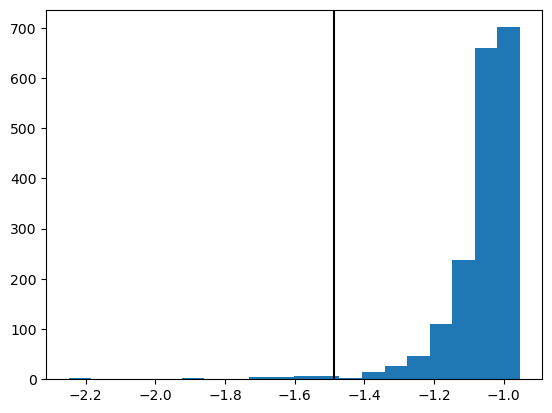

In [60]:
plt.hist(clf_LOF.negative_outlier_factor_, bins=20)
plt.axvline(np.min(clf_LOF.negative_outlier_factor_[np.where(y_pred==1)]), c='k')
plt.show()

Text(0.5, 1.0, 'LOF Outliers')

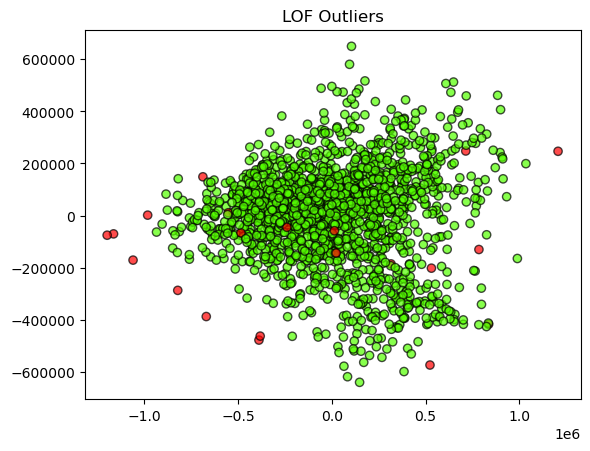

In [61]:
pca = PCA(n_components=2)
pca.fit(train)
X_pca = pca.transform(train)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.title("LOF Outliers")

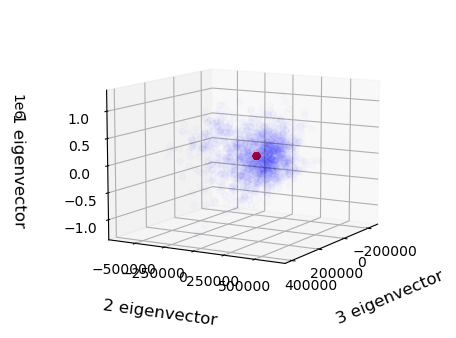

In [62]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

pca = PCA(n_components=3)
pca.fit(train)
X_pca = pca.transform(train)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection="3d")

x_vals = X_pca[:, 2]
y_vals = X_pca[:, 1]
z_vals = X_pca[:, 0]

ax.scatter(x_vals, y_vals, z_vals, c='b', alpha = 0.01)

x_vals = y_outliers[:, 2]
y_vals = y_outliers[:, 1]
z_vals = y_outliers[:, 0]
ax.scatter(x_vals, y_vals, z_vals, c = 'r')

ax.set_xlabel('3 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_ylabel('2 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15)
ax.set_zlabel('1 Eigenvector'.capitalize().replace("_", " "), fontsize =12, labelpad=15) 

ax.view_init(10, 30)
plt.show()

In [64]:
# list with indexes and scores only for outliers --> np.where(y_pred==-1)
outlier_indexes = np.where(y_pred==-1)[0]
outlier_scores = clf_LOF.negative_outlier_factor_[outlier_indexes]

outlier_factor_list = []
for i in range(0,len(outlier_scores)):
    outlier_factor_list.append((outlier_indexes[i], outlier_scores[i]))
print(len(outlier_factor_list))

#We sort in ascending order with respect to LOF factor
def outlier_score(elem):
    return elem[1]
outlier_factor_list = sorted(outlier_factor_list, key=outlier_score)
outlier_factor_list[:10]

23


[(1818, -2.2487259057666362),
 (1819, -2.2056117273292335),
 (352, -1.9829483825407228),
 (40, -1.9033070961103764),
 (1702, -1.8974581364634364),
 (1816, -1.751537433514384),
 (425, -1.717464946835788),
 (1367, -1.7077004038197185),
 (927, -1.699972617073082),
 (1815, -1.6780794831051309)]

top 1% outliers

In [65]:
top1perc = int(float(len(train))*0.01)
top1perc

top_outliers_LOF = outlier_factor_list[:top1perc]
print(len(top_outliers_LOF))

indexes_list = [i[0] for i in top_outliers_LOF] #retrieve indexes of outliers
df_LOF_outliers = df_train.iloc[indexes_list]
df_LOF_outliers

18


,vocal_channel,emotional_intensity,statement,repetition,sex,mean,q25,q50,q75,kur,...,stft_kur_w4,stft_skew_w4,emotion_angry,emotion_calm,emotion_disgust,emotion_fearful,emotion_happy,emotion_neutral,emotion_sad,emotion_surprised
1818,1,1,0,0,0,-1.590157e-08,-0.000366,0.000000,0.000397,17.369828,...,-0.950053,-0.356922,0,0,1,0,0,0,0,0
1819,1,1,0,1,0,-1.834512e-07,-0.000366,0.000000,0.000488,21.708608,...,-0.757745,-0.512022,0,0,1,0,0,0,0,0
352,1,1,1,0,0,-9.154192e-07,-0.001556,0.000000,0.001709,13.123943,...,-0.977898,0.520642,0,0,0,1,0,0,0,0
40,1,1,1,0,1,-9.970549e-07,-0.001160,0.000000,0.001007,19.281083,...,-1.072617,0.272193,0,0,0,1,0,0,0,0
1702,1,0,0,0,1,5.474721e-05,-0.003815,-0.000092,0.003723,20.580156,...,2.036498,-1.440128,0,0,0,1,0,0,0,0
1816,1,1,1,0,0,-1.897455e-07,-0.000122,0.000000,0.000153,23.689075,...,-1.152757,0.346435,0,0,1,0,0,0,0,0
425,1,1,1,1,1,1.323930e-07,-0.000061,0.000000,0.000061,51.805771,...,0.700807,-1.189344,0,1,0,0,0,0,0,0
1367,1,0,0,1,0,2.695109e-07,-0.000031,0.000000,0.000000,7.824765,...,0.846823,-1.062278,0,0,0,0,1,0,0,0
927,0,1,0,1,1,-5.549613e-06,-0.000183,0.000000,0.000183,14.133371,...,-1.154368,-0.270769,1,0,0,0,0,0,0,0
1815,1,0,0,1,0,-2.319982e-07,-0.000183,0.000000,0.000305,9.141644,...,-1.104861,0.149706,0,0,1,0,0,0,0,0


In [68]:
#retrieve track id of outliers
outliers_track_id = list(df_LOF_outliers.index)
outliers_track_id[:10]
print(len(outliers_track_id))

top_outliers_lof_track_id = []

for i, val in top_outliers_LOF:
    top_outliers_lof_track_id.append((df_train.iloc[i].name, val))
print(len(top_outliers_lof_track_id))

print("Track id with LOF score of outlierness")
top_outliers_lof_track_id


18
18
Track id with LOF score of outlierness


[(1818, -2.2487259057666362),
 (1819, -2.2056117273292335),
 (352, -1.9829483825407228),
 (40, -1.9033070961103764),
 (1702, -1.8974581364634364),
 (1816, -1.751537433514384),
 (425, -1.717464946835788),
 (1367, -1.7077004038197185),
 (927, -1.699972617073082),
 (1815, -1.6780794831051309),
 (1420, -1.6532321534886787),
 (832, -1.62270158920531),
 (1387, -1.6141024056909838),
 (1423, -1.6097481270804241),
 (314, -1.5867736041212903),
 (1714, -1.5750378884796181),
 (1422, -1.5656454739880505),
 (1729, -1.5443667201201232)]

DBSCAN

# Distance-based approach

KNN

# Angle-based approach

ABOD

# Model-based approach

ISOLATION FOREST